In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/ColabNotebooks'

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)
except ImportError as e:
    pass

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

df = pd.read_csv('dataset.csv')

df_target = df.copy()
df_data =df_target
df_target=df_target.drop(columns='text')
label_encoder = LabelEncoder()
df_target = label_encoder.fit_transform(df_target)

#df_data = df.copy()
df_data=df_data.drop(columns='humor')
df_data= np.array(df_data['text'])

df_data[:10]


c:\Users\Henry\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(["Joe biden rules out 2020 bid: 'guys, i'm not running'",
       'Watch: darvish gave hitter whiplash with slow pitch',
       'What do you call a turtle without its shell? dead.',
       '5 reasons the 2016 election feels so personal',
       'Pasco police shot mexican migrant from behind, new autopsy shows',
       'Martha stewart tweets hideous food photo, twitter responds accordingly',
       "What is a pokemon master's favorite kind of pasta? wartortellini!",
       'Why do native americans hate it when it rains in april? because it brings mayflowers.',
       "Obama's climate change legacy is impressive, imperfect and vulnerable",
       "My family tree is a cactus, we're all pricks."], dtype=object)

In [2]:
import itertools
import matplotlib.pyplot as plt


#Confusion matrix to evaluate models
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.preprocessing import DenseTransformer
import numpy as np
from sklearn.model_selection import train_test_split

# Create internal pipeline
classifier = GaussianNB(var_smoothing=2e-9)
tfidfVectorizer = TfidfVectorizer(stop_words='english')

#divide into different train/test sets to apply different sets to hyperparameter optimization and prediction
df_data_train, df_data_test, df_target_train, df_target_test = train_test_split(
    df_data, df_target, test_size=0.2, random_state=42)

#matrix = tfidfVectorizer.fit_transform(df_data['text'])

#df_data_tfidfVectorized = pd.DataFrame(matrix.toarray(), columns=tfidfVectorizer.get_feature_names())


pipeline = Pipeline(steps=[("transformer", tfidfVectorizer),('to_dense', DenseTransformer()), ("classification", classifier)])



# Specify the tunable hyper parameters
parameters = {
   'transformer__min_df': list(np.arange(0.0012, 0.0016, 0.0002)),
   #'transformer__max_df' : list(np.arange(0.05, 0.08, 0.01)),
   'transformer__max_features' : list(range(420, 440, 10)),
   #'transformer__stop_words' : ['english','none'] , 
   #'classification__var_smoothing': np.logspace(0,-9, num=100),
}

# Define KFold parameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
estimator = GridSearchCV(pipeline, parameters, scoring="accuracy", cv=cv, n_jobs=5)
estimator.fit(df_data_train, df_target_train)

print(estimator.best_params_)    

{'transformer__max_features': 430, 'transformer__min_df': 0.0014}


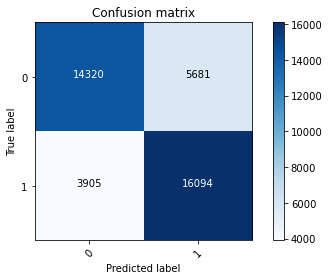

              precision    recall  f1-score   support

           0       0.79      0.72      0.75     20001
           1       0.74      0.80      0.77     19999

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



In [26]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels


prediction = cross_val_predict(estimator, df_data_test, df_target_test, cv=cv, n_jobs=-1)
cm = confusion_matrix(df_target_test, prediction)
plot_confusion_matrix(cm, classes=unique_labels(df_target_test))
print(classification_report(df_target_test, prediction))
plt.show()    